**Author:** Sasinda C. Prabhashana  
**Graduate Student, Memorial University, Canada**  
 

**Course:** *Design of Digital Signal Processing Systems – Project Winter 2025*

**Libraries:** 

In [73]:
import numpy as np               
import librosa                   
import librosa.display           
import scipy.signal as signal    
import noisereduce as nr         
import soundfile as sf           
import matplotlib.pyplot as plt  
import os                        
import pandas as pd              

**Filter Design**

In [74]:
def bandpass_filter(audio, sr, low_cutoff=100, high_cutoff=4000):
    #10th-order Butterworth bandpass filter 
    sos = signal.butter(10, [low_cutoff, high_cutoff], btype='bandpass', fs=sr, output='sos')
    return signal.sosfilt(sos, audio)

**Spectral Subtraction**

In [75]:
def spectral_subtraction(S, num_noise_frames=10): 
    noise_est = np.mean(S[:, :num_noise_frames], axis=1, keepdims=True) 
    return np.maximum(S - noise_est, 0)

**Spectral Temporal Coherence Calculation**

In [76]:
def compute_coherence(S_clean, sr, n_fft):
    coherence_vals = []  
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)  
    speech_band = (freqs >= 100) & (freqs <= 4000)  

    # Iterate over consecutive frames
    for i in range(S_clean.shape[1] - 1):
        frame_current = S_clean[speech_band, i] 
        frame_next = S_clean[speech_band, i+1]  
        
        if np.max(np.abs(frame_current)) < 1e-10 or np.max(np.abs(frame_next)) < 1e-10:
            coherence_vals.append(0.0)
            continue
        
        # Normalize frames to unit amplitude
        f_cur = frame_current / np.max(np.abs(frame_current))
        f_nxt = frame_next / np.max(np.abs(frame_next))

        # Compute correlation coefficient (coherence)
        cov = np.mean((f_cur - np.mean(f_cur)) * (f_nxt - np.mean(f_nxt)))
        std_cur = np.std(f_cur)
        std_nxt = np.std(f_nxt)
        rho = cov / (std_cur * std_nxt + 1e-10)  
        coherence_vals.append(rho)
    
    return np.array(coherence_vals)  

**Energy-Based Thresholding**

In [77]:
def baseline_energy_removal(y, sr, top_db=20): 
    intervals = librosa.effects.split(y, top_db=top_db)
    y_baseline = np.concatenate([y[start:end] for start, end in intervals]) 
    max_val = np.max(np.abs(y_baseline)) + 1e-10  
    y_baseline = y_baseline / max_val
    return y_baseline, intervals  

**Conversion to Time Intervals**

In [78]:
def frames_to_intervals(frame_mask, hop_length, frame_length):
    intervals = []  # Store start-end sample pairs
    in_speech = False  # For tracking the speech state
    start_idx = 0  
    
    # Iterate through frames to detect speech segments
    for i, is_speech in enumerate(frame_mask):
        if is_speech and not in_speech:
            in_speech = True
            start_idx = i
        elif not is_speech and in_speech:
            end_idx = i
            start_sample = start_idx * hop_length
            end_sample = end_idx * hop_length + frame_length
            intervals.append([start_sample, end_sample])
            in_speech = False
    
    # Handle case where audio ends in speech
    if in_speech:
        end_idx = len(frame_mask)
        start_sample = start_idx * hop_length
        end_sample = end_idx * hop_length + frame_length
        intervals.append([start_sample, end_sample])
    
    return intervals

**Reconstruction with Crossfading**

In [79]:
def crossfade_segments(y, intervals, fade_len=256):
    if not intervals:  # Return empty array if no intervals
        return np.array([])
    
    output = y[intervals[0][0] : intervals[0][1]].copy() 
    
    # Process remaining segments
    for i in range(1, len(intervals)):
        seg_start, seg_end = intervals[i]
        new_segment = y[seg_start:seg_end]
        
        overlap = min(fade_len, len(output), len(new_segment))  # overlap length
        if overlap < 1:  
            output = np.concatenate([output, new_segment])
            continue
        
        # Apply fade-out to end of current output
        fade_out = np.linspace(1.0, 0.0, overlap)
        output[-overlap:] = output[-overlap:] * fade_out
        
        # Apply fade-in to start of new segment
        fade_in = np.linspace(0.0, 1.0, overlap)
        new_segment[:overlap] = new_segment[:overlap] * fade_in
        
        output = np.concatenate([output, new_segment[overlap:]])  
    
    return output

**Coherence and Energy Removal**

In [80]:
def coherence_energy_removal(y, sr, n_fft=1024, hop_length=512, frame_length=1024):
    # Compute Short-Time Fourier Transform (STFT) of the audio
    stft_data = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')
    S_orig = np.abs(stft_data)  # Magnitude spectrogram
    S_clean = spectral_subtraction(S_orig, num_noise_frames=10)  # Noise-reduced spectrogram
    coherence_vals = compute_coherence(S_clean, sr, n_fft)  # Compute coherence
    avg_coherence = np.mean(coherence_vals)  # Average coherence for reporting
    coherence_threshold = np.percentile(coherence_vals, 70)   #percentile as threshold
    frame_mask_coh = (coherence_vals > coherence_threshold)  # Coherence-based mask
    frame_mask_coh = np.pad(frame_mask_coh, (0, 1), mode='edge') 
    
    # Compute energy (RMS) for each frame
    energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    energy_thresh = 0.5 * np.mean(energy)  # Threshold at half mean energy
    frame_mask_energy = (energy > energy_thresh)  
    
    # Combine coherence and energy masks (logical OR)
    final_frame_mask = frame_mask_coh | frame_mask_energy
    intervals = frames_to_intervals(final_frame_mask, hop_length, frame_length) 
    y_processed = crossfade_segments(y, intervals, fade_len=256)  # Reconstruct with crossfading
    max_val = np.max(np.abs(y_processed)) + 1e-10  
    y_processed = y_processed / max_val
    return y_processed, intervals, avg_coherence  

**Helper Functions for Metrics**

In [81]:
def get_file_size_in_kb(file_path):
    return os.path.getsize(file_path) / 1024

#time reduction percentage
def compute_time_reduction(original, processed, sr):
    original_duration = len(original) / sr  
    processed_duration = len(processed) / sr
    return (1 - processed_duration / (original_duration + 1e-10)) * 100  

**Main Function**

In [82]:
def main():
    audio_file = r"C:\Users\prabh\OneDrive\Disk Drive A\Apps\Softwares\Desktop\DSP Project Implementation\a.wav"
    output_dir = r"C:\Users\prabh\OneDrive\Disk Drive A\Apps\Softwares\Desktop\DSP"
    
    # Validate file and directory existence
    if not os.path.exists(audio_file):
        raise FileNotFoundError(f" Error: The file {audio_file} does not exist. Please check the path.")
    if not os.path.exists(output_dir):
        print(f" Output directory {output_dir} does not exist. Creating it now...")
        os.makedirs(output_dir)  
    
    try:
        # Load and preprocess audio
        print(f"Loading audio file: {audio_file}")
        y, sr = librosa.load(audio_file, sr=44000)  
        y = y / (np.max(np.abs(y)) + 1e-10)  
        print("Applying bandpass filter...")
        y_filtered = bandpass_filter(y, sr)  
        print("Reducing noise...")
        y_denoised = nr.reduce_noise(y=y_filtered, sr=sr, prop_decrease=0.85) 
        
        # Process with Proposed Method
        print("Processing with Proposed Method...")
        y_coherence, intervals_coh, avg_coh = coherence_energy_removal(y_denoised, sr)
        advanced_output = os.path.join(output_dir, "final_processed_audio.wav")
        sf.write(advanced_output, y_coherence, sr)  
        print(f"Saved advanced method output to: {advanced_output}")
        
        # Process with Energy-Based Method
        print("Processing with Energy-Based Method...")
        y_baseline, intervals_base = baseline_energy_removal(y_denoised, sr, top_db=20)
        baseline_output = os.path.join(output_dir, "energy-based method_audio.wav")
        sf.write(baseline_output, y_baseline, sr)  
        print(f"Saved baseline method output to: {baseline_output}")
        
        # Compute metrics for comparison
        original_wav_path = os.path.join(output_dir, "original_temp.wav")
        sf.write(original_wav_path, y, sr)  
        print(f"Saved temporary original file to: {original_wav_path}")
        
        advanced_size = get_file_size_in_kb(advanced_output) 
        baseline_size = get_file_size_in_kb(baseline_output)
        original_size = get_file_size_in_kb(original_wav_path)
        
        advanced_file_size_reduction = (1 - advanced_size / (original_size + 1e-10)) * 100  
        baseline_file_size_reduction = (1 - baseline_size / (original_size + 1e-10)) * 100
        
        original_rms = np.mean(librosa.feature.rms(y=y)) 
        advanced_rms = np.mean(librosa.feature.rms(y=y_coherence))
        baseline_rms = np.mean(librosa.feature.rms(y=y_baseline))
        advanced_energy_reduction = (1 - advanced_rms / original_rms) * 100 
        baseline_energy_reduction = (1 - baseline_rms / original_rms) * 100
        
        # Create comparison table
        results = [
            {
                "Method": "Advanced (Coherence+Energy)",
                "File Size Reduction (%)": advanced_file_size_reduction,
                "Speech Energy Reduction (%)": advanced_energy_reduction,
                "Avg. Coherence": avg_coh
            },
            {
                "Method": "Energy-Based Thresholding",
                "File Size Reduction (%)": baseline_file_size_reduction,
                "Speech Energy Reduction (%)": baseline_energy_reduction,
                "Avg. Coherence": "N/A"
            }
        ]
        
        df = pd.DataFrame(results)
        print("\nComparison Table:\n")
        print(df.to_string(index=False))  
        
        # Clean up temporary file
        if os.path.exists(original_wav_path):
            os.remove(original_wav_path)
            print(f"Cleaned up temporary file: {original_wav_path}")
        
        return y, y_coherence, y_baseline, sr  
    
    except Exception as e:
        print(f" An error occurred during processing: {str(e)}")
        return None  

**Execution and Plotting**

Loading audio file: C:\Users\prabh\OneDrive\Disk Drive A\Apps\Softwares\Desktop\DSP Project Implementation\a.wav
Applying bandpass filter...
Reducing noise...
Processing with Proposed Method...
Saved advanced method output to: C:\Users\prabh\OneDrive\Disk Drive A\Apps\Softwares\Desktop\DSP\final_processed_audio.wav
Processing with Energy-Based Method...
Saved baseline method output to: C:\Users\prabh\OneDrive\Disk Drive A\Apps\Softwares\Desktop\DSP\energy-based method_audio.wav
Saved temporary original file to: C:\Users\prabh\OneDrive\Disk Drive A\Apps\Softwares\Desktop\DSP\original_temp.wav

Comparison Table:

                     Method  File Size Reduction (%)  Speech Energy Reduction (%) Avg. Coherence
Advanced (Coherence+Energy)                38.676537                    13.527721       0.772485
  Energy-Based Thresholding                65.561832                   -40.609288            N/A
Cleaned up temporary file: C:\Users\prabh\OneDrive\Disk Drive A\Apps\Softwares\Desktop\DSP

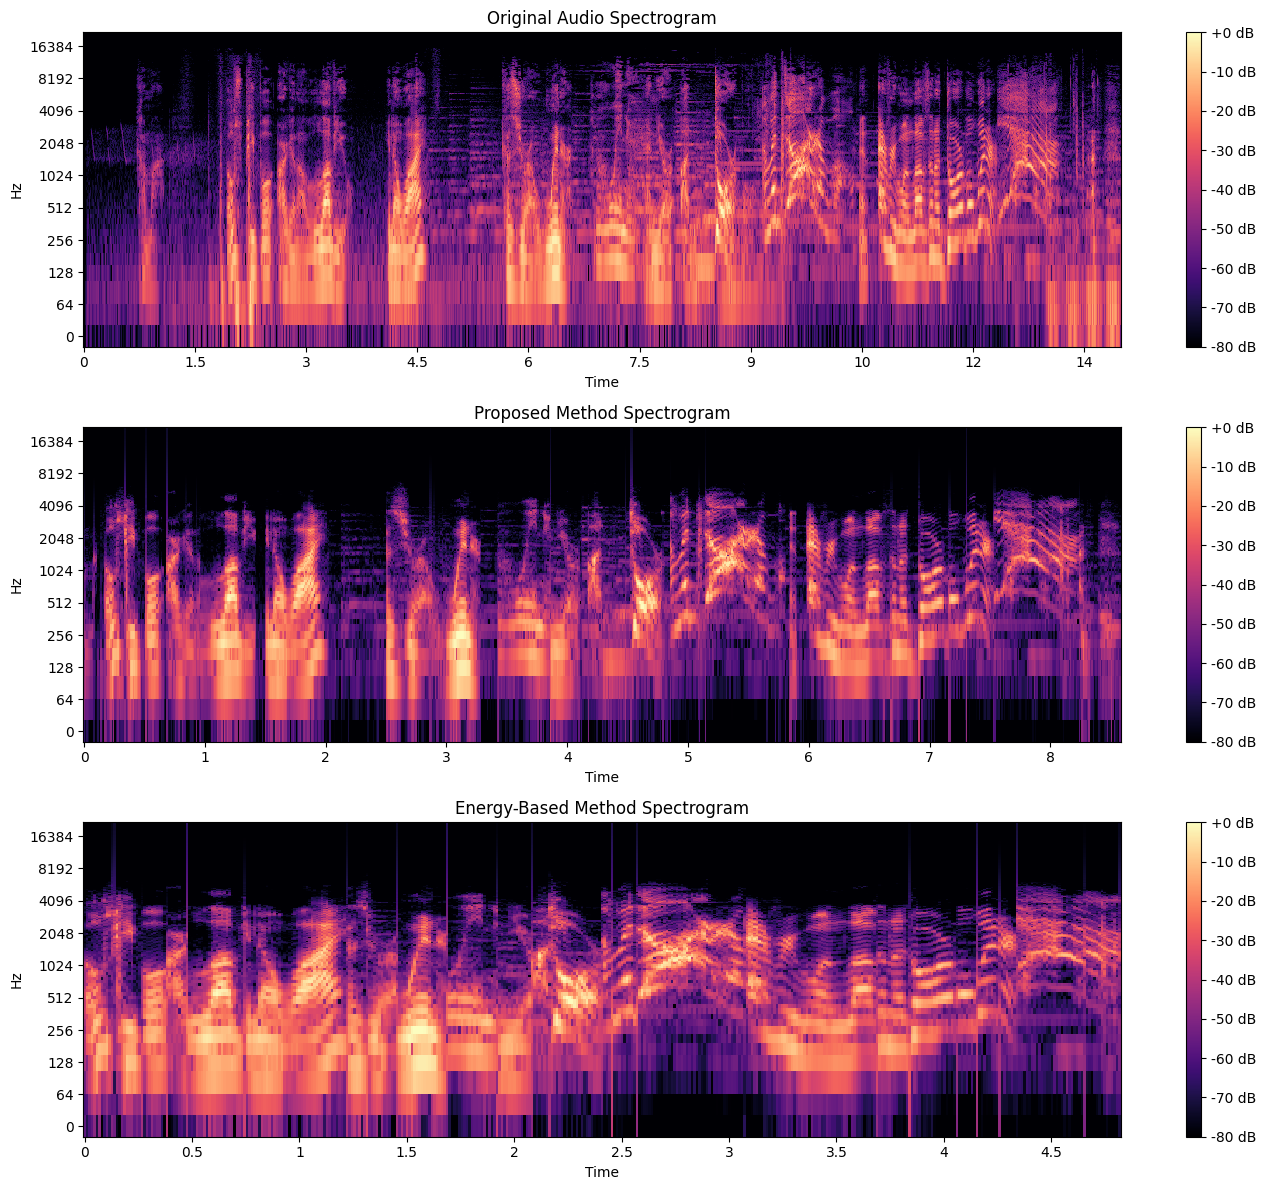

Generating waveform plots...


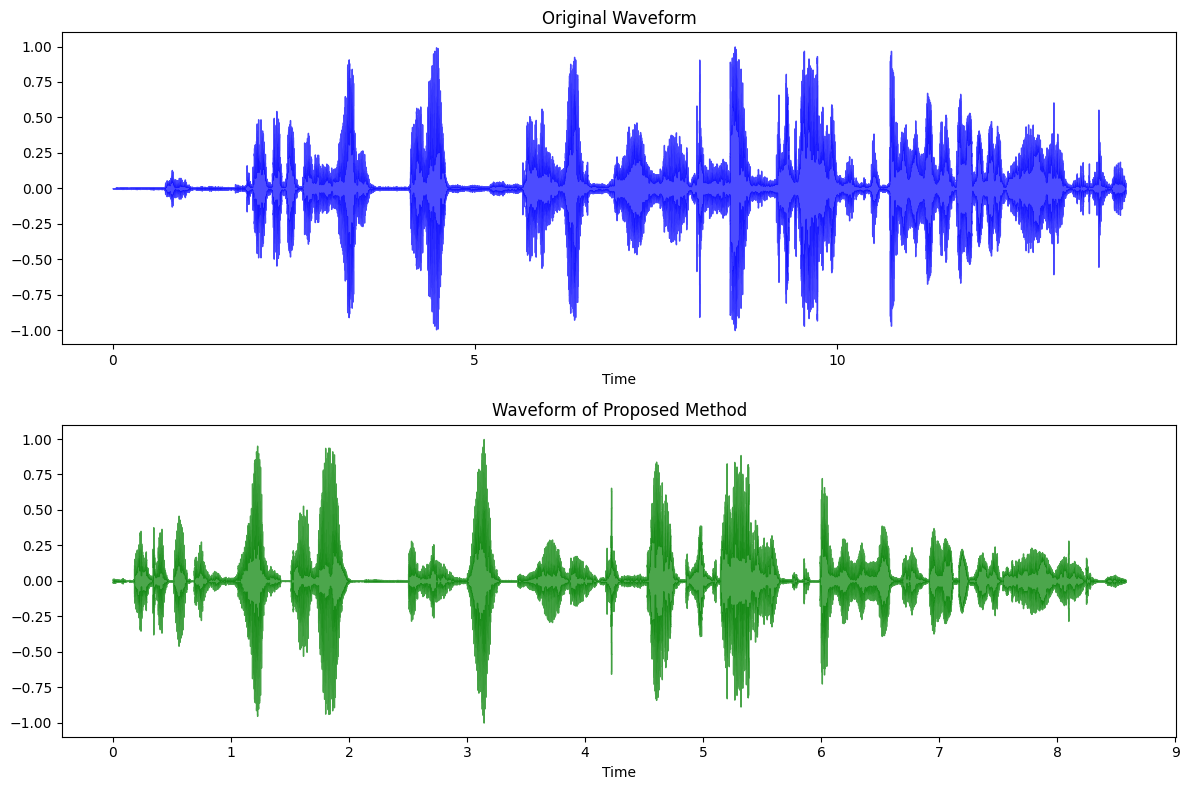

In [83]:
if __name__ == "__main__":
    result = main()
    if result is None:
        print(" Main function failed. Check the error messages above and verify file paths or dependencies.")
    else:
        y, y_coherence, y_baseline, sr = result 
        
        def plot_spectrograms(y, y_coherence, y_baseline, sr):
            # Compute STFT and convert to dB scale for original audio
            S_orig = np.abs(librosa.stft(y, n_fft=1024, hop_length=512, window='hann'))
            D_orig = librosa.amplitude_to_db(S_orig, ref=np.max)
            
            # Compute STFT and convert to dB scale for advanced method
            S_adv = np.abs(librosa.stft(y_coherence, n_fft=1024, hop_length=512, window='hann'))
            D_adv = librosa.amplitude_to_db(S_adv, ref=np.max)
            
            # Compute STFT and convert to dB scale for baseline method
            S_base = np.abs(librosa.stft(y_baseline, n_fft=1024, hop_length=512, window='hann'))
            D_base = librosa.amplitude_to_db(S_base, ref=np.max)
            
            # Create figure with three subplots
            plt.figure(figsize=(14, 12))
            plt.subplot(3,1,1)
            librosa.display.specshow(D_orig, sr=sr, hop_length=512, x_axis='time', y_axis='log', cmap='magma')
            plt.colorbar(format='%+2.0f dB')
            plt.title("Original Audio Spectrogram")
            
            plt.subplot(3,1,2)
            librosa.display.specshow(D_adv, sr=sr, hop_length=512, x_axis='time', y_axis='log', cmap='magma')
            plt.colorbar(format='%+2.0f dB')
            plt.title("Proposed Method Spectrogram")
            
            plt.subplot(3,1,3)
            librosa.display.specshow(D_base, sr=sr, hop_length=512, x_axis='time', y_axis='log', cmap='magma')
            plt.colorbar(format='%+2.0f dB')
            plt.title("Energy-Based Method Spectrogram")
            
            plt.tight_layout()
            plt.show()
        
        # Plot spectrograms
        print("Generating spectrogram plots...")
        plot_spectrograms(y, y_coherence, y_baseline, sr)
        
        # Plot waveforms
        print("Generating waveform plots...")
        plt.figure(figsize=(12, 8))
        
        # Original waveform
        plt.subplot(2,1,1)
        librosa.display.waveshow(y, sr=sr, alpha=0.7, color='blue')
        plt.title("Original Waveform")
        
        # Processed waveform (using Proposed Method)
        plt.subplot(2,1,2)
        librosa.display.waveshow(y_coherence, sr=sr, alpha=0.7, color='green')
        plt.title("Waveform of Proposed Method")
        
        plt.tight_layout()
        plt.show()